In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings. filterwarnings('ignore')

In [43]:
# Loading the datasets
#HPI = pd.read_csv("USSTHPI.csv") # Quarterly HPI data
HPI_PO = pd.read_csv("HPI_Purchase_only_yoy_change.csv") # HPI Purchase Only data
EHS = pd.read_excel("Existing Home Sales.xlsx") # Existing Home Sales data, Chris supplied
StockQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "Stock_Quarterly") # Housing Stock data, Chris supplied
# Just chaging the column name and cleaning the data
HPI_PO.DATE = pd.to_datetime(HPI_PO.DATE)
new_name = {'HPIPONM226S_PC1' : "YoY_HPI"}
HPI_PO.rename(columns=new_name, inplace= True)
HPI_PO.drop(HPI_PO.tail(1).index, inplace= True)
HPI_PO.YoY_HPI = HPI_PO.YoY_HPI.astype(float)
StockQt.rename(columns={"Unnamed: 15" : "col 15", "Unnamed: 16" : "Eff_HS_US"}, inplace=True)
StockQt.drop(columns=["col 15"], inplace= True)
StockQt.dropna(subset=["Eff_HS_US"],inplace = True)
Quarters = StockQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
StockQt.Quarter = Dates
EHS.EOM = pd.to_datetime(EHS.EOM)
EHS.rename(columns= {"EOM" : "DATE"}, inplace = True)
EHS.dropna(subset=["Existing Home Sales"], inplace=True)
EHS["DATE"] = EHS.DATE.dt.to_period('Q')
EHS_Q = pd.DataFrame(EHS.groupby("DATE").mean())
EHS_Q.reset_index(inplace= True)
EHS_Q.drop(EHS_Q.tail(1).index,inplace=True)
EHS_Q["House_Stock"] = StockQt.Eff_HS_US.values
EHS_Q["Implied_Turnover"] = (EHS_Q["Existing Home Sales"]/(EHS_Q.House_Stock/1000))*100
Turnover = list(EHS_Q.Implied_Turnover.values)
Turnover = [np.nan]*(HPI_PO.shape[0]-len(Turnover))+Turnover
HPI_PO["Implied_Turnover"] = Turnover
HPI_PO["YoY_HPI_MA_6"] = HPI_PO.YoY_HPI.rolling(6).mean()
for i in range(6):
    HPI_PO[f'YOY_HPI_Lag_{i+1}']= HPI_PO['YoY_HPI'].shift(i+1)
HPI_df = HPI_PO.dropna().reset_index(drop=True)
HCAI = pd.read_csv("HCAI_WM.csv")
HCAI.rename(columns = {'Total\nRisk':'Total_Risk', 'Borrower\nRisk':'Borrower_Risk', 'Product\nRisk':'Product_Risk'}, inplace = True)
HCAI = HCAI[4:].reset_index(drop=True)
num_col = ['Total_Risk', 'Borrower_Risk', 'Product_Risk']
for col in num_col:
    HCAI[col] = HCAI[col].astype('float64')
HCAI_index = HCAI.index.to_list()
HCAI_Y = HCAI.Year.values
HCAI_Q = HCAI.Quarter.values
Quarter_to_Date = {1 : "-01-01", 2 : "-04-01",  3 : "-07-01", 4 : "-10-01"}
Dates = []
for i in HCAI_index:
    date = str(HCAI_Y[i])+Quarter_to_Date[HCAI_Q[i]]
    Dates.append(date)
HCAI['DATE'] = pd.to_datetime(Dates)
HCAI.drop(['Year', 'Quarter'], axis=1, inplace=True)
df_hpi_hcai=HPI_df.merge(HCAI, how='left')
df_hpi_hcai.drop(['Borrower_Risk', 'Product_Risk'], axis=1, inplace=True)
df_hpi_hcai.rename(columns={'Total_Risk':'HCAI'}, inplace = True)
df_hpi_hcai.fillna(method="ffill", inplace=True)

In [44]:
df_hpi_hcai

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_6,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,YOY_HPI_Lag_5,YOY_HPI_Lag_6,HCAI
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,11.236
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,11.790
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,13.209
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,14.332
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,14.764
...,...,...,...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,5.125
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,5.145
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,5.169
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,5.169


In [45]:
HORQt = pd.read_excel("HousingStockWorksheet.xlsx", sheet_name = "HOR_Quarterly")

In [46]:
HORQt.dropna(subset=["Quarter"], inplace=True)

In [47]:
HORQt

,Quarter,HOR_US,HOR_NE,HOR_MW,HOR_S,HOR_W,HOR_METCC,HOR_METOCC,HOR_NONMET,HOR_lt25,...,HOR_NHWA,HOR_NHBA,HOR_NHORA,HOR_NHTMR,HOR_HIS,HOR_MCWC,HOR_MCWOC,HOR_OFWC,HOR_OFWOC,HOC_OTHTYP
0,1997 Q1,65.4,61.6,70.6,67.8,59.000000,49.800000,72.100000,73.400000,17.300000,...,71.6,45.0,52.6,NaN,42.6,76.000000,84.600000,37.500000,66.400000,49.200000
1,1997 Q2,65.7,62.4,70.3,68.1,59.900000,49.900000,72.600000,73.500000,18.700000,...,72.1,44.9,53.4,NaN,43.3,76.800000,84.900000,38.700000,67.300000,49.200000
2,1997 Q3,66,63,70.7,68.2,59.800000,50.200000,72.600000,74.000000,18.300000,...,72.3,45.8,54.1,NaN,43.0,76.800000,84.900000,38.700000,66.200000,49.700000
3,1997 Q4,65.7,62.7,70.4,67.8,59.800000,49.700000,72.600000,73.800000,16.700000,...,71.9,45.7,53.3,NaN,44.0,76.600000,85.100000,39.000000,65.700000,48.900000
4,1998 Q1,65.9,62.4,70.6,68.2,60.100000,49.900000,72.800000,74.100000,17.500000,...,72.1,46.0,52.9,NaN,44.4,76.600000,85.100000,40.100000,65.800000,49.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2020 Q3,67.4,62,71.2,70.8,62.100000,53.200000,74.100000,77.000000,27.200000,...,75.8,46.7,61.4,52.8,50.9,77.800000,85.900000,46.000000,63.400000,53.000000
95,2020 Q4,65.822503,62.55456,70.764276,67.678557,60.383668,51.006586,73.150970,74.833305,23.796695,...,74.5,44.8,59.4,52.2,49.1,76.700000,85.400000,43.000000,62.700000,51.400000
96,2021 Q1,65.6,63.1,70.3,67.4,59.700000,50.300000,73.000000,74.500000,24.666667,...,73.8,45.7,60.2,51.6,49.3,77.200000,84.800000,43.100000,63.000000,50.900000
97,2021 Q2,65.4,61.8,70.7,67.1,60.100000,50.400000,72.600000,75.100000,23.726086,...,74.2,45.2,59.5,51.6,47.5,76.500000,85.100000,42.900000,63.100000,50.600000


In [48]:
Quarters = HORQt.Quarter.values
Quarter_to_Date = {"Q1" : "-01-01",
                  "Q2" : "-04-01",
                  "Q3" : "-07-01",
                  "Q4" : "-10-01"}
Dates = []
for i in Quarters:
    y = i.split()[0]
    y+= Quarter_to_Date[i.split()[1]]
    Dates.append(y)
HORQt.Quarter = Dates
HORQt.Quarter = pd.to_datetime(HORQt.Quarter)

In [49]:
HORQt.columns

Index(['Quarter', 'HOR_US', 'HOR_NE', 'HOR_MW', 'HOR_S', 'HOR_W', 'HOR_METCC',
       'HOR_METOCC', 'HOR_NONMET', 'HOR_lt25', 'HOR_25to29', 'HOR_30to34',
       'HOR_35to44', 'HOR_45to54', 'HOR_55to64', 'HOR_gte65', 'HOR_NHWA',
       'HOR_NHBA', 'HOR_NHORA', 'HOR_NHTMR', 'HOR_HIS', 'HOR_MCWC',
       'HOR_MCWOC', 'HOR_OFWC', 'HOR_OFWOC', 'HOC_OTHTYP'],
      dtype='object')

In [50]:
HORQt = HORQt[['Quarter', 'HOR_US', 'HOR_gte65']]

In [51]:
HORQt['HOR_YoY']=0
HORQt['HOR_senior_YoY']=0

In [52]:
HORQt

,Quarter,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY
0,1997-01-01,65.4,79.200000,0,0
1,1997-04-01,65.7,79.100000,0,0
2,1997-07-01,66,79.200000,0,0
3,1997-10-01,65.7,79.100000,0,0
4,1998-01-01,65.9,79.100000,0,0
...,...,...,...,...,...
94,2020-07-01,67.4,80.700000,0,0
95,2020-10-01,65.822503,80.246841,0,0
96,2021-01-01,65.6,79.277985,0,0
97,2021-04-01,65.4,79.604935,0,0


In [53]:
for i in range(4,99):
    HORQt.loc[i, 'HOR_YoY'] = 100*(HORQt.loc[i, 'HOR_US']/HORQt.loc[i-4,'HOR_US'] -1)
    HORQt.loc[i, 'HOR_senior_YoY'] = 100*(HORQt.loc[i, 'HOR_gte65']/HORQt.loc[i-4,'HOR_gte65'] -1)
HORQt

,Quarter,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY
0,1997-01-01,65.4,79.200000,0.000000,0.000000
1,1997-04-01,65.7,79.100000,0.000000,0.000000
2,1997-07-01,66,79.200000,0.000000,0.000000
3,1997-10-01,65.7,79.100000,0.000000,0.000000
4,1998-01-01,65.9,79.100000,0.764526,-0.126263
...,...,...,...,...,...
94,2020-07-01,67.4,80.700000,4.012346,2.281369
95,2020-10-01,65.822503,80.246841,1.109836,1.578279
96,2021-01-01,65.6,79.277985,0.459418,0.734415
97,2021-04-01,65.4,79.604935,-3.681885,-0.988886


In [54]:
HORQt.drop(HORQt.head(4).index,inplace=True)
HORQt.reset_index(inplace= True, drop = True)
HORQt

,Quarter,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY
0,1998-01-01,65.9,79.100000,0.764526,-0.126263
1,1998-04-01,66,79.200000,0.456621,0.126422
2,1998-07-01,66.8,79.700000,1.212121,0.631313
3,1998-10-01,66.4,79.200000,1.065449,0.126422
4,1999-01-01,66.7,79.800000,1.213961,0.884956
...,...,...,...,...,...
90,2020-07-01,67.4,80.700000,4.012346,2.281369
91,2020-10-01,65.822503,80.246841,1.109836,1.578279
92,2021-01-01,65.6,79.277985,0.459418,0.734415
93,2021-04-01,65.4,79.604935,-3.681885,-0.988886


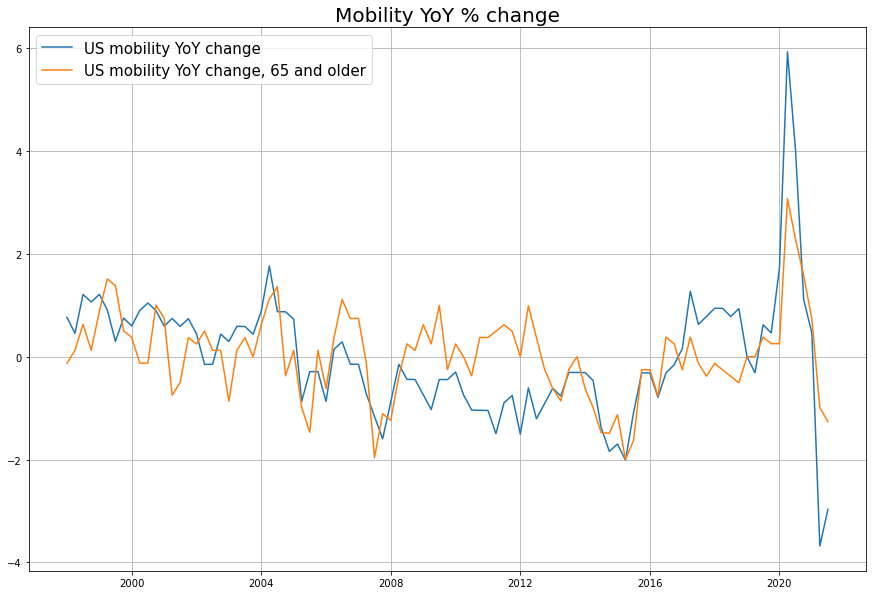

In [55]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(HORQt.Quarter, HORQt.HOR_YoY.values, label = "US mobility YoY change")
plt.plot(HORQt.Quarter, HORQt.HOR_senior_YoY.values, label = "US mobility YoY change, 65 and older")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Mobility YoY % change", size = 20);

In [56]:
HORQt["HOR_YoY_2QA"] = HORQt.HOR_YoY.rolling(2).mean()
HORQt["HOR_YoY_3QA"] = HORQt.HOR_YoY.rolling(3).mean()
HORQt["HOR_YoY_4QA"] = HORQt.HOR_YoY.rolling(4).mean()
HORQt["HOR_YoY_5QA"] = HORQt.HOR_YoY.rolling(5).mean()
HORQt["HOR_YoY_6QA"] = HORQt.HOR_YoY.rolling(6).mean()
HORQt["HOR_senior_YoY_2QA"] = HORQt.HOR_senior_YoY.rolling(2).mean()
HORQt["HOR_senior_YoY_3QA"] = HORQt.HOR_senior_YoY.rolling(3).mean()
HORQt["HOR_senior_YoY_4QA"] = HORQt.HOR_senior_YoY.rolling(4).mean()
HORQt["HOR_senior_YoY_5QA"] = HORQt.HOR_senior_YoY.rolling(5).mean()
HORQt["HOR_senior_YoY_6QA"] = HORQt.HOR_senior_YoY.rolling(6).mean()
HORQt

,Quarter,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1998-01-01,65.9,79.100000,0.764526,-0.126263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-04-01,66,79.200000,0.456621,0.126422,0.610573,NaN,NaN,NaN,NaN,0.000080,NaN,NaN,NaN,NaN
2,1998-07-01,66.8,79.700000,1.212121,0.631313,0.834371,0.811089,NaN,NaN,NaN,0.378868,0.210491,NaN,NaN,NaN
3,1998-10-01,66.4,79.200000,1.065449,0.126422,1.138785,0.911397,0.874679,NaN,NaN,0.378868,0.294719,0.189474,NaN,NaN
4,1999-01-01,66.7,79.800000,1.213961,0.884956,1.139705,1.163844,0.987038,0.942536,NaN,0.505689,0.547564,0.442278,0.328570,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2020-07-01,67.4,80.700000,4.012346,2.281369,4.970291,3.884659,3.029235,2.547612,2.071170,2.679146,1.871023,1.466719,1.249711,1.041426
91,2020-10-01,65.822503,80.246841,1.109836,1.578279,2.561091,3.683473,3.190954,2.645355,2.307983,1.929824,2.312190,1.797837,1.489031,1.304472
92,2021-01-01,65.6,79.277985,0.459418,0.734415,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
93,2021-04-01,65.4,79.604935,-3.681885,-0.988886,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146


In [57]:
 HORQt.drop(HORQt.head(4).index,inplace=True)
HORQt.reset_index(inplace= True, drop = True)
HORQt

,Quarter,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1999-01-01,66.7,79.800000,1.213961,0.884956,1.139705,1.163844,0.987038,0.942536,NaN,0.505689,0.547564,0.442278,0.328570,NaN
1,1999-04-01,66.6,80.400000,0.909091,1.515152,1.061526,1.062833,1.100155,0.971449,0.936961,1.200054,0.842177,0.789461,0.656853,0.526334
2,1999-07-01,67,80.800000,0.299401,1.380176,0.604246,0.807484,0.871975,0.940005,0.859441,1.447664,1.260094,0.976676,0.907604,0.777407
3,1999-10-01,66.9,79.600000,0.753012,0.505051,0.526207,0.653835,0.793866,0.848183,0.908839,0.942613,1.133459,1.071333,0.882351,0.840511
4,2000-01-01,67.1,80.100000,0.599700,0.375940,0.676356,0.550704,0.640301,0.755033,0.806769,0.440495,0.753722,0.944079,0.932255,0.797949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-07-01,67.4,80.700000,4.012346,2.281369,4.970291,3.884659,3.029235,2.547612,2.071170,2.679146,1.871023,1.466719,1.249711,1.041426
87,2020-10-01,65.822503,80.246841,1.109836,1.578279,2.561091,3.683473,3.190954,2.645355,2.307983,1.929824,2.312190,1.797837,1.489031,1.304472
88,2021-01-01,65.6,79.277985,0.459418,0.734415,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
89,2021-04-01,65.4,79.604935,-3.681885,-0.988886,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146


In [58]:
HORQt.rename(columns={'Quarter':'DATE'}, inplace = True)
HORQt

,DATE,HOR_US,HOR_gte65,HOR_YoY,HOR_senior_YoY,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1999-01-01,66.7,79.800000,1.213961,0.884956,1.139705,1.163844,0.987038,0.942536,NaN,0.505689,0.547564,0.442278,0.328570,NaN
1,1999-04-01,66.6,80.400000,0.909091,1.515152,1.061526,1.062833,1.100155,0.971449,0.936961,1.200054,0.842177,0.789461,0.656853,0.526334
2,1999-07-01,67,80.800000,0.299401,1.380176,0.604246,0.807484,0.871975,0.940005,0.859441,1.447664,1.260094,0.976676,0.907604,0.777407
3,1999-10-01,66.9,79.600000,0.753012,0.505051,0.526207,0.653835,0.793866,0.848183,0.908839,0.942613,1.133459,1.071333,0.882351,0.840511
4,2000-01-01,67.1,80.100000,0.599700,0.375940,0.676356,0.550704,0.640301,0.755033,0.806769,0.440495,0.753722,0.944079,0.932255,0.797949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,2020-07-01,67.4,80.700000,4.012346,2.281369,4.970291,3.884659,3.029235,2.547612,2.071170,2.679146,1.871023,1.466719,1.249711,1.041426
87,2020-10-01,65.822503,80.246841,1.109836,1.578279,2.561091,3.683473,3.190954,2.645355,2.307983,1.929824,2.312190,1.797837,1.489031,1.304472
88,2021-01-01,65.6,79.277985,0.459418,0.734415,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
89,2021-04-01,65.4,79.604935,-3.681885,-0.988886,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146


In [59]:
df_hpi_hcai

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_6,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,YOY_HPI_Lag_5,YOY_HPI_Lag_6,HCAI
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,11.236
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,11.790
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,13.209
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,14.332
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,14.764
...,...,...,...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,5.125
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,5.145
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,5.169
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,5.169


In [60]:
df_hpi_hcai_HOR=df_hpi_hcai.merge(HORQt, how='left')

In [61]:
df_hpi_hcai_HOR

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_6,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,YOY_HPI_Lag_5,YOY_HPI_Lag_6,...,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,...,1.139705,1.163844,0.987038,0.942536,NaN,0.505689,0.547564,0.442278,0.328570,NaN
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,...,1.061526,1.062833,1.100155,0.971449,0.936961,1.200054,0.842177,0.789461,0.656853,0.526334
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,...,0.604246,0.807484,0.871975,0.940005,0.859441,1.447664,1.260094,0.976676,0.907604,0.777407
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,...,0.526207,0.653835,0.793866,0.848183,0.908839,0.942613,1.133459,1.071333,0.882351,0.840511
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,...,0.676356,0.550704,0.640301,0.755033,0.806769,0.440495,0.753722,0.944079,0.932255,0.797949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,...,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,...,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,...,-3.324622,-2.063275,-1.269998,-0.213529,0.810099,-1.125961,-0.505836,0.015193,0.468428,0.903177
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
df_hpi_hcai_HOR.columns

Index(['DATE', 'YoY_HPI', 'Implied_Turnover', 'YoY_HPI_MA_6', 'YOY_HPI_Lag_1',
       'YOY_HPI_Lag_2', 'YOY_HPI_Lag_3', 'YOY_HPI_Lag_4', 'YOY_HPI_Lag_5',
       'YOY_HPI_Lag_6', 'HCAI', 'HOR_US', 'HOR_gte65', 'HOR_YoY',
       'HOR_senior_YoY', 'HOR_YoY_2QA', 'HOR_YoY_3QA', 'HOR_YoY_4QA',
       'HOR_YoY_5QA', 'HOR_YoY_6QA', 'HOR_senior_YoY_2QA',
       'HOR_senior_YoY_3QA', 'HOR_senior_YoY_4QA', 'HOR_senior_YoY_5QA',
       'HOR_senior_YoY_6QA'],
      dtype='object')

In [67]:
columns = ['HOR_US', 'HOR_gte65', 'HOR_YoY',
       'HOR_senior_YoY', 'HOR_YoY_2QA', 'HOR_YoY_3QA', 'HOR_YoY_4QA',
       'HOR_YoY_5QA', 'HOR_YoY_6QA', 'HOR_senior_YoY_2QA',
       'HOR_senior_YoY_3QA', 'HOR_senior_YoY_4QA', 'HOR_senior_YoY_5QA',
       'HOR_senior_YoY_6QA']
for col in columns:
    df_hpi_hcai_HOR[col][91] = df_hpi_hcai_HOR[col][90]
    df_hpi_hcai_HOR[col][92] = df_hpi_hcai_HOR[col][90]
df_hpi_hcai_HOR

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_6,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,YOY_HPI_Lag_5,YOY_HPI_Lag_6,...,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,...,1.139705,1.163844,0.987038,0.942536,NaN,0.505689,0.547564,0.442278,0.328570,NaN
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,...,1.061526,1.062833,1.100155,0.971449,0.936961,1.200054,0.842177,0.789461,0.656853,0.526334
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,...,0.604246,0.807484,0.871975,0.940005,0.859441,1.447664,1.260094,0.976676,0.907604,0.777407
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,...,0.526207,0.653835,0.793866,0.848183,0.908839,0.942613,1.133459,1.071333,0.882351,0.840511
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,...,0.676356,0.550704,0.640301,0.755033,0.806769,0.440495,0.753722,0.944079,0.932255,0.797949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,...,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,...,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,...,-3.324622,-2.063275,-1.269998,-0.213529,0.810099,-1.125961,-0.505836,0.015193,0.468428,0.903177
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,...,-3.324622,-2.063275,-1.269998,-0.213529,0.810099,-1.125961,-0.505836,0.015193,0.468428,0.903177


In [68]:
df_hpi_hcai_HOR['HOR_YoY_6QA'][0] = 1.2
df_hpi_hcai_HOR['HOR_senior_YoY_6QA'][0] =  0.5

In [69]:
df_hpi_hcai_HOR

,DATE,YoY_HPI,Implied_Turnover,YoY_HPI_MA_6,YOY_HPI_Lag_1,YOY_HPI_Lag_2,YOY_HPI_Lag_3,YOY_HPI_Lag_4,YOY_HPI_Lag_5,YOY_HPI_Lag_6,...,HOR_YoY_2QA,HOR_YoY_3QA,HOR_YoY_4QA,HOR_YoY_5QA,HOR_YoY_6QA,HOR_senior_YoY_2QA,HOR_senior_YoY_3QA,HOR_senior_YoY_4QA,HOR_senior_YoY_5QA,HOR_senior_YoY_6QA
0,1999-01-01,5.93694,6.477936,4.762640,5.70589,5.16140,4.52891,3.91376,3.32894,2.80875,...,1.139705,1.163844,0.987038,0.942536,1.200000,0.505689,0.547564,0.442278,0.328570,0.500000
1,1999-04-01,6.02527,6.529750,5.212028,5.93694,5.70589,5.16140,4.52891,3.91376,3.32894,...,1.061526,1.062833,1.100155,0.971449,0.936961,1.200054,0.842177,0.789461,0.656853,0.526334
2,1999-07-01,6.29097,6.447134,5.608230,6.02527,5.93694,5.70589,5.16140,4.52891,3.91376,...,0.604246,0.807484,0.871975,0.940005,0.859441,1.447664,1.260094,0.976676,0.907604,0.777407
3,1999-10-01,6.14804,6.359195,5.878085,6.29097,6.02527,5.93694,5.70589,5.16140,4.52891,...,0.526207,0.653835,0.793866,0.848183,0.908839,0.942613,1.133459,1.071333,0.882351,0.840511
4,2000-01-01,6.46462,6.412796,6.095288,6.14804,6.29097,6.02527,5.93694,5.70589,5.16140,...,0.676356,0.550704,0.640301,0.755033,0.806769,0.440495,0.753722,0.944079,0.932255,0.797949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,2021-01-01,13.08681,6.684530,8.340382,11.17118,8.25959,5.76118,6.23889,5.52464,4.99680,...,0.784627,1.860533,2.877459,2.644646,2.281033,1.156347,1.531354,1.917747,1.585153,1.363262
89,2021-04-01,17.81826,6.321918,10.389318,13.08681,11.17118,8.25959,5.76118,6.23889,5.52464,...,-1.611234,-0.704210,0.474929,1.565590,1.590225,-0.127236,0.441269,0.901294,1.336420,1.156146
90,2021-07-01,18.60512,6.440745,12.450357,17.81826,13.08681,11.17118,8.25959,5.76118,6.23889,...,-3.324622,-2.063275,-1.269998,-0.213529,0.810099,-1.125961,-0.505836,0.015193,0.468428,0.903177
91,2021-10-01,17.70045,6.539117,14.440235,18.60512,17.81826,13.08681,11.17118,8.25959,5.76118,...,-3.324622,-2.063275,-1.269998,-0.213529,0.810099,-1.125961,-0.505836,0.015193,0.468428,0.903177


In [70]:
df_hpi_hcai_HOR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                93 non-null     datetime64[ns]
 1   YoY_HPI             93 non-null     float64       
 2   Implied_Turnover    93 non-null     float64       
 3   YoY_HPI_MA_6        93 non-null     float64       
 4   YOY_HPI_Lag_1       93 non-null     float64       
 5   YOY_HPI_Lag_2       93 non-null     float64       
 6   YOY_HPI_Lag_3       93 non-null     float64       
 7   YOY_HPI_Lag_4       93 non-null     float64       
 8   YOY_HPI_Lag_5       93 non-null     float64       
 9   YOY_HPI_Lag_6       93 non-null     float64       
 10  HCAI                93 non-null     float64       
 11  HOR_US              93 non-null     object        
 12  HOR_gte65           93 non-null     float64       
 13  HOR_YoY             93 non-null     float64       
 

In [75]:
df_hpi_hcai_HOR.HOR_US = df_hpi_hcai_HOR.HOR_US.astype(float)
df_hpi_hcai_HOR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                93 non-null     datetime64[ns]
 1   YoY_HPI             93 non-null     float64       
 2   Implied_Turnover    93 non-null     float64       
 3   YoY_HPI_MA_6        93 non-null     float64       
 4   YOY_HPI_Lag_1       93 non-null     float64       
 5   YOY_HPI_Lag_2       93 non-null     float64       
 6   YOY_HPI_Lag_3       93 non-null     float64       
 7   YOY_HPI_Lag_4       93 non-null     float64       
 8   YOY_HPI_Lag_5       93 non-null     float64       
 9   YOY_HPI_Lag_6       93 non-null     float64       
 10  HCAI                93 non-null     float64       
 11  HOR_US              93 non-null     float64       
 12  HOR_gte65           93 non-null     float64       
 13  HOR_YoY             93 non-null     float64       
 

In [76]:
drop_fe = ['DATE', 'Implied_Turnover']
features = [col for col in list(df_hpi_hcai_HOR.columns) if col not in drop_fe]
features

['YoY_HPI',
 'YoY_HPI_MA_6',
 'YOY_HPI_Lag_1',
 'YOY_HPI_Lag_2',
 'YOY_HPI_Lag_3',
 'YOY_HPI_Lag_4',
 'YOY_HPI_Lag_5',
 'YOY_HPI_Lag_6',
 'HCAI',
 'HOR_US',
 'HOR_gte65',
 'HOR_YoY',
 'HOR_senior_YoY',
 'HOR_YoY_2QA',
 'HOR_YoY_3QA',
 'HOR_YoY_4QA',
 'HOR_YoY_5QA',
 'HOR_YoY_6QA',
 'HOR_senior_YoY_2QA',
 'HOR_senior_YoY_3QA',
 'HOR_senior_YoY_4QA',
 'HOR_senior_YoY_5QA',
 'HOR_senior_YoY_6QA']

In [77]:
import statsmodels.api as sm
from scipy import stats

def test_features():
    for col in features:
        X = df_hpi_hcai_HOR[col]
        y = df_hpi_hcai_HOR['Implied_Turnover']
        X1 = sm.add_constant(X)
        print(f'========================== p-value table of {col} ==============================')
        print(sm.OLS(y,X1).fit().summary())
        print('=======================================================================================')

In [78]:
test_features()

========================== p-value table of YoY_HPI ==============================
                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     100.8
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.12e-16
Time:                        13:39:26   Log-Likelihood:                -97.191
No. Observations:                  93   AIC:                             198.4
Df Residuals:                      91   BIC:                             203.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
========================== p-value table of HOR_senior_YoY_2QA ==============================
                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.6350
Date:                Mon, 25 Jul 2022   Prob (F-statistic):              0.428
Time:                        13:39:26   Log-Likelihood:                -131.53
No. Observations:                  93   AIC:                             267.1
Df Residuals:                      91   BIC:                             272.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        

In [80]:
new_fea = ['YoY_HPI_MA_6', 'HCAI', 'HOR_YoY_6QA']
X = df_hpi_hcai_HOR[new_fea]
Y = df_hpi_hcai_HOR['Implied_Turnover']
X1 = sm.add_constant(X)
model = sm.OLS(Y, X1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Implied_Turnover   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     138.1
Date:                Mon, 25 Jul 2022   Prob (F-statistic):           2.24e-33
Time:                        13:57:18   Log-Likelihood:                -51.280
No. Observations:                  93   AIC:                             110.6
Df Residuals:                      89   BIC:                             120.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.4853      0.117     38.363   

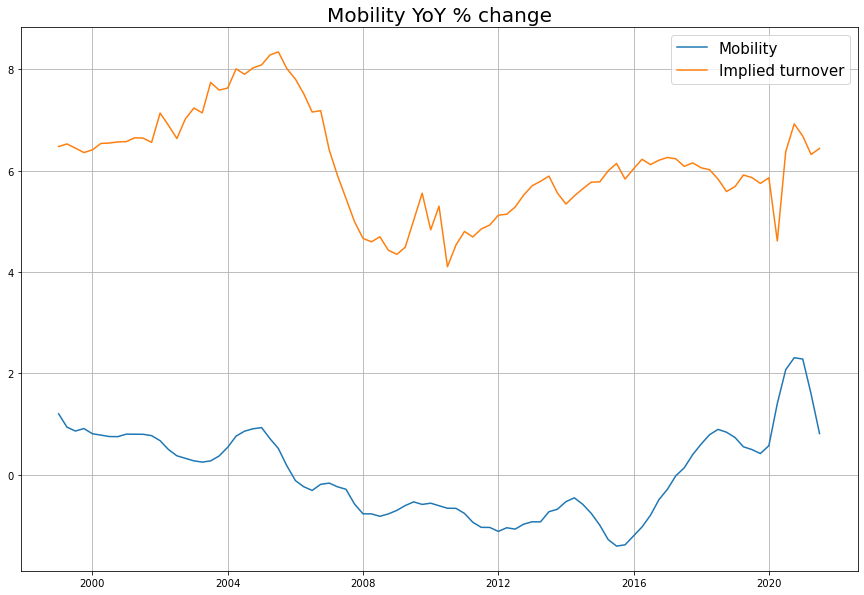

In [40]:
plt.figure(figsize=(15,10))
#plt.plot(HPI_PO.DATE, HPI_PO.YoY.values, label = "Yearly change in HPI (%)")
plt.plot(df_hpi_hcai_HOR.DATE, df_hpi_hcai_HOR.HOR_YoY_6QA.values, label = "Mobility")
plt.plot(df_hpi_hcai_HOR.DATE, df_hpi_hcai_HOR.Implied_Turnover.values, label = "Implied turnover")
plt.legend(fontsize = 15)
plt.grid()
plt.title("Mobility YoY % change", size = 20);

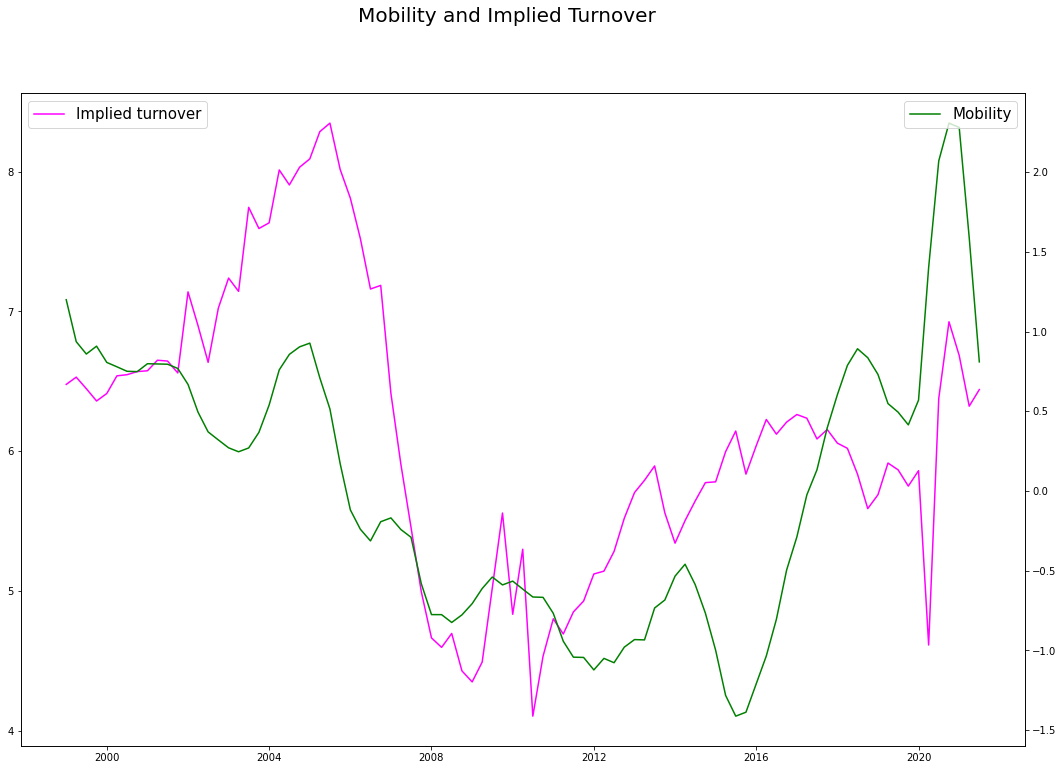

In [41]:
fig,ax1 = plt.subplots()
fig.set_figheight(12)
fig.set_figwidth(18)
ax1.plot(df_hpi_hcai_HOR.DATE, df_hpi_hcai_HOR.Implied_Turnover, linewidth=1.5,label='Implied turnover', color = 'magenta')
ax2 = ax1.twinx()
ax2.plot(df_hpi_hcai_HOR.DATE, df_hpi_hcai_HOR.HOR_YoY_6QA, linewidth=1.5,color='green',label='Mobility')
ax1.legend(loc='upper left', fontsize=15)
ax2.legend(loc='upper right', fontsize=15)
fig.suptitle("Mobility and Implied Turnover", size = 20)
plt.show()